1. На основе учебного ноутбука проведите финальную подготовку данных. Иизмените количество сегментирующих классов с `16` на `5`.

2. Проведите суммарно не менее `10` экспериментов и визуализируйте их результаты (включая точность обучения сетей на одинаковом количестве эпох, например, на `7`):

  - изменив `filters` в сверточных слоях
  - изменив `kernel_size` в сверточных слоях
  - изменив активационную функцию в скрытых слоях с `relu` на `linear` или/и `selu`, `elu`.


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

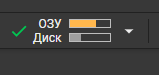



Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:11<00:00, 19.2MB/s]


In [ ]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки
IMG_HEIGHT = 256              # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 0.36c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.35c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


## Решение


In [ ]:
# Ваше решение